# PCA и t-SNE, или зачем понижать размерность?

### PCA

**Метод главных компонент, или PCA (Principal Components Analysis) — это один из базовых способов уменьшения размерности.**

Теперь рассмотрим работу с PCA на практике. Из датасетов sklearn импортируем датасет MNIST — это данные, основанные на рукописном начертании цифр:

In [47]:
from scipy.io import loadmat
dataset = loadmat("data/mnist-original.mat")
mnist_data = dataset["data"].T
mnist_label = dataset["label"][0]



In [48]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [49]:
# загрузим датасет MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


# загрузим признаки в переменную X  
X = dataset['data'].T
# загрузим «ответы» в переменную y
#y = dataset['target']
y= dataset["label"][0]
# разделим данные с помощью sklearn на данные для обучения и теста
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

# импортируем StandardScaler для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
# трансформируем датасеты train_x и test_x
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# импортируем класс PCA
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=300)
pca.fit(train_x)
# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

Посмотрим, сколько признаков описывало объект до и после уменьшения размерности. Как мы можем заметить, сначала было 787 признаков, а в конце объект описывают уже 300 главных компонент:

In [50]:
print(len(train_x[0]))
print(len(train_x_pca[0]))

784
300


Обучим модель логистической регрессии, которая на вход будет принимать пиксели изображения и предсказывать, что на нём нарисовано.

Напишем функцию, которая будет принимать на вход данные для обучения (матрицу с признаками и правильные ответы) и данные для тестирования модели, а на выходе будет возвращать время, затраченное на обучение модели, и качество модели. В качестве метрики оценивания качества будем использовать метрику accuracy.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

# напишем функцию, которая на вход принимает X и y, а возвращает модель и время
def get_time_and_accuracy(train_x, train_y, test_x, test_y):
    # создадим объект класса LogisticRegression
    log_reg_model = LogisticRegression(max_iter=1000)
    # запишем время с начала эпохи в секундах до обучения модели
    start_time = time()
    # обучим модель
    log_reg_model.fit(train_x, train_y)    
    # запишем время с начала эпохи в секундах после обучения
    end_time = time()
    # подсчитаем время, потраченное на обучение модели
    delta_time = end_time-start_time
    # предскажем на тестовых данных
    y_pred = log_reg_model.predict(test_x)
    # посчитаем скор для тестового предсказания
    score = accuracy_score(test_y, y_pred)
    # вернём время, потраченное на обучение, и качество полученной модели
    return delta_time, score

model_pca_time, model_pca_acc = get_time_and_accuracy(train_x_pca, train_y, test_x_pca, test_y)
print(f"Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения {model_pca_time}, метрика модели {model_pca_acc}")
# Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 54.12072825431824, метрика модели 0.9255714285714286

model_time, model_acc = get_time_and_accuracy(train_x, train_y, test_x, test_y)
print(f"Модель, построенная на всех исходных признаках. Время обучения {model_time}, метрика модели {model_acc}")
# Модель, построенная на всех исходных признаках. Время обучения 108.04033303260803, метрика модели 0.9187142857142857

Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 23.588050603866577, метрика модели 0.9244285714285714
Модель, построенная на всех исходных признаках. Время обучения 32.06254053115845, метрика модели 0.917


***

### t-SNE

Для того чтобы визуализировать многомерное пространство признаков, необходимо уменьшить его размерность до двухмерного или трёхмерного. В этом поможет t-SNE (t-distributed Stochastic Neighbor Embedding), что переводится с английского как «стохастическое вложение соседей с t-распределением». 

t-SNE, в отличие от PCA, использует технику нелинейного снижения размерности данных. Обычно используется снижение размерности многомерного пространства до двух- или трёхмерного с целью дальнейшей визуализации. При преобразовании похожие объекты оказываются рядом, а непохожие — далеко друг от друга.

Важные параметры для запуска:
* n_components — размерность нового пространства.
* perplexity — один из важнейших параметров для запуска. Этот параметр описывает ожидаемую плотность вокруг точки. Таким образом мы можем устанавливать соотношение ближайших соседей к точке. Если датасет большой, стоит установить большее значение perplexity. Обычно используют значения в диапазоне от 5 до 50.
* n_iter — количество итераций для оптимизации.
* random_state — так как в алгоритме есть случайность, задание random_state позволяет от запуска к запуску получать одинаковые результаты.

Теперь попробуем уменьшить размерность и визуализировать пространство пикселей, которые описывают данные рукописного начертания цифр. Сравним, какая визуализация получается при использовании PCA и tSNE.

* Уменьшим размерность с помощью PCA:

<Axes: xlabel='0', ylabel='1'>

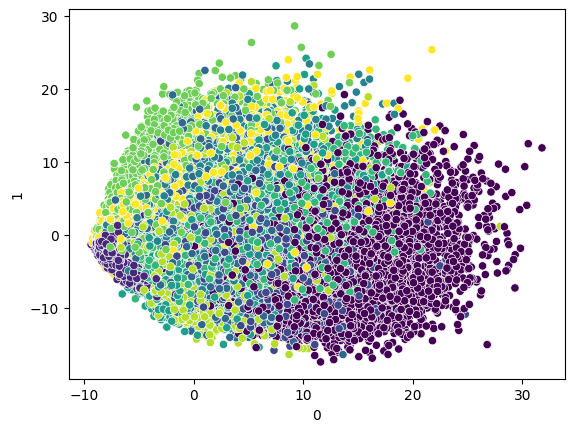

In [58]:
import seaborn as sns
import pandas as pd

# создадим объект класса PCA, уменьшим размерность данных до 2
pca = PCA(n_components=2, random_state=42)
# уменьшим размерность данных
X_reduced = pca.fit_transform(train_x)
# сохраним данные в датафрейм
df_pca = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_pca['c'] = pd.to_numeric(train_y)
# визуализируем
sns.scatterplot(x=df_pca[0], y=df_pca[1], c=df_pca['c'])

* Уменьшим размерность с помощью t-SNE:

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

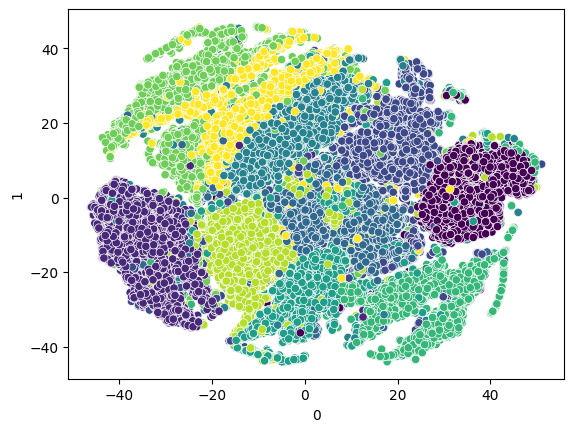

In [59]:
from sklearn.manifold import TSNE


# создадим объект класса TSNE, уменьшим размерность данных до 2
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=42)
# уменьшим размерность данных
X_reduced = tsne.fit_transform(train_x)
# сохраним данные в датафрейм
df_tsne = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_tsne['c'] = pd.to_numeric(train_y)
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], c=df_tsne['c'])